# Notebook2: Classical Feedforward and Control Flow

Let's import the necessary packages.

In [3]:
### Import the required packages

import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [4]:
import qiskit

qiskit.__version__

'1.3.0'

## Part 1: Intro To Classical feedforward and control flow

The Qiskit educational resource, the [Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-circuits), includes the following statement:
>_"A quantum circuit is a computational routine consisting of coherent quantum operations on qubits ... It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation."_

The last sentence of this quote might seem unclear at first. However, it is directly related to **classical feedforward and control flow**, also referred to as **dynamic circuits**. When we use the term *quantum circuit* without qualifiers, it typically refers to a *state* quantum circuit. So, what are dynamic circuits?

Up to now, the quantum circuits you've encountered always started in the $|0\rangle$ state, applied quantum gates, and concluded with a measurement. In contrast, **dynamic circuits** measure qubits midway through the process and use the measurement results to determine which quantum gates to apply next. These measurement results are classical values—lacking quantum properties like superposition—and conditioning subsequent quantum operations based on these classical results is known as **classical feedforward**.

Why is classical feedforward important?

One key example of classical feedforward is the conditional reset process, which is represented by the [`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html) operation in Qiskit. A reset is a non-unitary operation that forces a qubit into the $|0\rangle$ state, regardless of its previous state. This is done as follows:
1. Measure the qubit
2. If the result is $|0\rangle$, no action is taken.
3. If the result is $|1\rangle$, an $X$-gate is applied to reset the qubit to $|0\rangle$.

In other words, the qubit is measured, collapsing its state to either $|0\rangle$ or $|1\rangle$. If it collapses to $|1\rangle$, an $X$-gate is applied to reset the qubit to $|0\rangle$. Since this operation depends on the measurement result, circuits that include conditional resets are considered dynamic circuits.

<center>
<img src="./img/sketch-1.png" width="50%">
</center>

Dynamic circuits can be thought of as quantum circuits that incorporate control flow structures such as "if" statements and "while" loops.

### Hello Dynamic Circuit World

IBM Quantum's real quantum computers have supported mid-circuit measurements and resets from long time ago. However, the ability to use measurement results to determine how to apply subsequent quantum gates via **classical feedforward** was only introduced in 2022. Implementing this feature required a major redesign of the control systems and associated software.

The most basic way to implement classical feedforward is by using the [`if_test()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test) method of the `QuantumCircuit` class.

Let's go through an example of using the `if_test()` method to implement the conditional reset, which was previously discussed as part of dynamic circuits. We will create the quantum circuit with the following steps:

1. Create a quantum circuit with 1 qubit and 2 classical bits (we’ll name the qubit `q0` and the classical bits `b0` and `b1`).
2. Apply a Hadamard gate to `q0`.
3. Measure `q0` and store the result in `b0`.
4. Use the `if_test` command to check if `b0 == 1`.
5. If `b0 == 1`, apply an $X$-gate to `q0`, resetting it to the $|0\rangle$ state.
6. Measure `q0` again, store the result in `b1`, and check if the value is always 0.

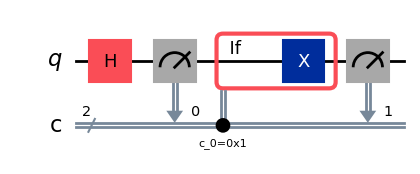

In [5]:
qr = QuantumRegister(1, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

Now that we have created the quantum circuit, we will run it multiple times. The first measurement will yield 0 or 1 with equal probability, while the second measurement will always result in 0. Please verify this behavior.

In [6]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'01': 4978, '00': 5022}


As expected, the first measurement can result in either 0 or 1, but the second measurement will always yield 0. Remember that Qiskit uses little-endian ordering. The rightmost bit in the string represents the first bit (`b0`), and the leftmost bit represents the second bit (`b1`).

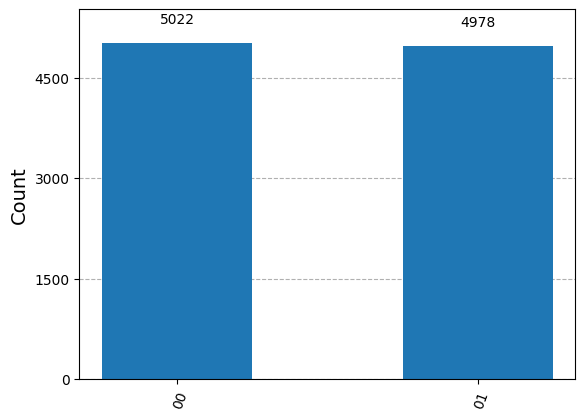

In [7]:
plot_histogram(counts_sampler)

In the previous example, we created a circuit that performs a specific action when a measurement satisfies a certain condition. But what if we want to apply an operation when a specific condition is **not** met? Does the `else` statement from Python come to mind? A similar concept exists in dynamic circuits as well. You can implement this using the code below.

In [6]:
with qc.if_test(조건) as else_:
    # Actions to perform when the condition is satisfied
    
with else_:
    # Actions to perform when the condition is not satisfied

IndentationError: expected an indented block after 'with' statement on line 1 (3587900472.py, line 4)

The example is provided below.

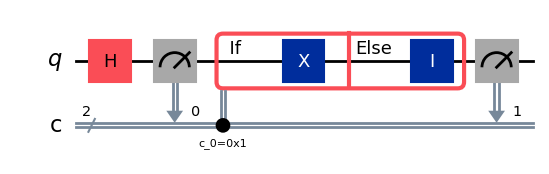

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)) as else_:
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)


with else_:
    # if the condition is satisfied (b0 != 1), then apply identity operator to 0
    qc.id(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

Now, let's create your own dynamic circuit!

<div class="alert alert-block alert-success">

### Exercise 1: Your First Classical Feedforward and Control Flow

In this exercise, you will create a slightly more complex circuit. The goal is to build a quantum circuit with 2 qubits and 2 classical bits, where the operation applied to `q1` depends on the measurement result of `q0`. Specifically, if the measurement result of `q0` is 0, you should apply an \(X\)-gate to `q1`, and if the measurement result of `q0` is 1, you should apply a Hadamard gate to `q1`. The instructions are outlined below.

**What You Need to Do:**  
In the code cell below, a Hadamard gate is first applied to `q0` to introduce randomness in its measurement result. After that, the measurement result of `q0` will be stored in `b0`. Based on the classical feedforward condition mentioned earlier, you will then apply a gate to `q1` and store the result of measuring `q1` in `b1`.

If you're having trouble writing the `if_test()` statement, please refer to the [documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test) for more details on how to use it.

**Note:** You should use the `if_test()` statement only once.

</div>


In [ ]:
qr = QuantumRegister(2, name = "q")
cr = ClassicalRegister(2, name = "b")
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


### Write your code below this line ### 



### Do not change the code below this line ###


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

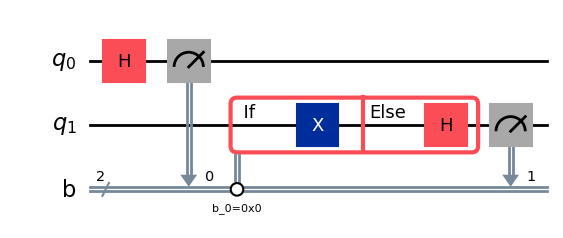

In [9]:
### solution ###

qr = QuantumRegister(2, name = "q")
cr = ClassicalRegister(2, name = "b")
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


### Write your code below this line ### 
with qc.if_test((b0, 0)) as else_:
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q1)

with else_:
    # if the condition is satisfied (b0 != 1), then apply identity operator to 0
    qc.h(q1)
### Do not change the code below this line ###


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

You can verify if your circuit works correctly below. It might be helpful to think about what results you should expect before running the code cell below.

In [10]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.b.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'10': 4928, '01': 2519, '11': 2553}


## Part 2: Another Method for Classical Feedforward and Control Flow

Classical feedforward and control flow can also be implemented using methods other than `if_test()`. In this section, we will explain the `switch`, `for_loop`, and `while_loop` methods.

- If statement - [`QuantumCircuit.if_test`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test)
- Switch statement - [`QuantumCircuit.switch`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#switch)
- For loop - [`QuantumCircuit.for_loop`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#for_loop)
- While loop - [`QuantumCircuit.while_loop`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#while_loop)

### Switch Statement

The `switch` statement is used to select an action based on the value of a classical bit. It is similar to the `if_test()` statement but is more convenient when you need to specify multiple cases for branching logic. If you have worked with programming languages that support `switch` statements (e.g., C, or Python 3.10 and later), this syntax will be familiar to you. 

In the example below, a 1-qubit quantum circuit applies a Hadamard gate to a qubit and measures the result. If the measurement outcome is 0, an $X$-gate is applied to the qubit; if the outcome is 1, a $Z$-gate is applied. The final measurement result should be 1 with 100% probability.

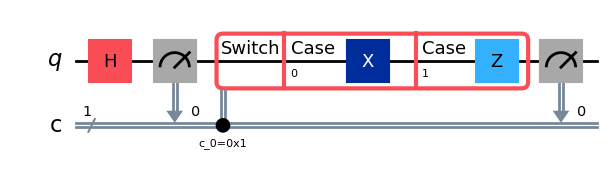

In [11]:
qubits = QuantumRegister(1, name='q')
clbits = ClassicalRegister(1, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.switch(c0) as case:
    with case(0):
        circuit.x(q0)
    with case(1):
        circuit.z(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")
 
# example output counts: {'1': 1024}

In [12]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'1': 10000}


In the previous example, we used a single classical bit, so there were only two possible outcomes, which could be achieved using an `if-else` statement. The `switch` statement is particularly useful when dealing with multiple bits in a classical register and handling more complex branching scenarios. The following example demonstrates this, including how to define a default case that will execute when no other case matches. Note that the `switch` statement only executes one block, and does not continue into sub-blocks.

In the example below, Hadamard gates are applied to two qubits before measurement:

- If the measurement result is either 00 or 11, a $Z$-gate is applied to the third qubit.
- If the measurement result is 01, a $Y$-gate is applied to the third qubit.
- If none of the previous cases match, an $X$-gate is applied.
- Finally, measure the third qubit

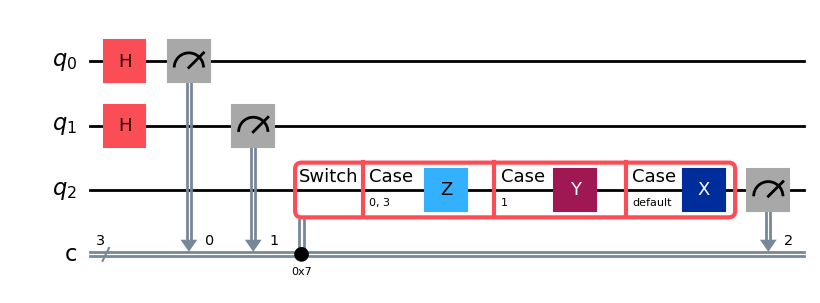

In [13]:
qubits = QuantumRegister(3, name='q')
clbits = ClassicalRegister(3, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits
 
circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.switch(clbits) as case:
    with case(0b000, 0b011):
        circuit.z(q2)
    with case(0b001):
        circuit.y(q2)
    with case(case.DEFAULT):
        circuit.x(q2)
circuit.measure(q2, c2)
 
circuit.draw("mpl")

### For Loop

A `for` loop is used to iterate over a sequence of classical values, performing certain operations in each iteration.

In the example below, a `for` loop is used to apply 5 $X$-gates to a single qubit, followed by a measurement. Since the $X$-gate is applied an odd number of times, the final effect is to flip the qubit from $|0\rangle$ to $|1\rangle$.

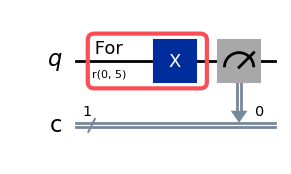

In [14]:
qubits = QuantumRegister(1, name='q')
clbits = ClassicalRegister(1, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
with circuit.for_loop(range(5)) as _:
    circuit.x(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")

In [15]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'1': 10000}


### While Loop

A `while` loop is used to repeat a set of operations as long as a certain condition is met.

In the example below, two qubits are subjected to Hadamard gates and then measured. A `while` loop is created to repeat this procedure until the measurement result is not `11`. As a result, the final measurement will never be `11`, and the other possible outcomes should appear with roughly equal frequency.

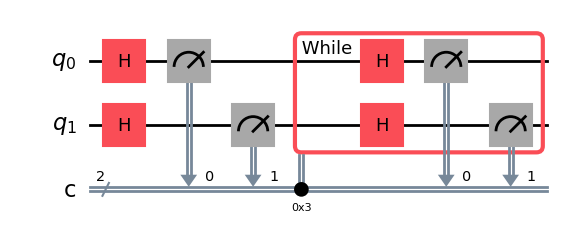

In [16]:
qubits = QuantumRegister(2, name='q')
clbits = ClassicalRegister(2, name='c')
circuit = QuantumCircuit(qubits, clbits)
 
q0, q1 = qubits
c0, c1 = clbits
 
circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.while_loop((clbits, 0b11)):
    circuit.h([q0, q1])
    circuit.measure(q0, c0)
    circuit.measure(q1, c1)
 
circuit.draw("mpl")

In [17]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'01': 3297, '00': 3373, '10': 3330}


### Break Loop, Continue Loop

`Break` and `Continue` are two important commands used for controlling the flow within loops. These commands allow you to stop or skip iterations in a loop based on specific conditions.

- `break_loop`: This command **terminates** the loop entirely. When `break` is executed within a loop such as a `for` loop or `while` loop, the loop is immediately exited, and the code following the loop is executed. It is typically used to stop the loop when a certain condition is met. In Qiskit, specific conditions are defined using the `c_if` method.

- `continue_loop`: This command **skips the current iteration** and proceeds to the next iteration of the loop. The loop itself does not terminate; instead, the code after `continue` is ignored, and the next iteration begins. It is used when you want to skip part of the loop under certain conditions and continue with the next iteration.

Let’s look at an example. Without the `break` statement, 10 X gates would be applied, and the final measurement should result in 0. However, with the `break` statement, the loop exits when the measurement is 1 (after applying one X gate), and you’ll observe that 1 is measured.

C:\ProgramData\Anaconda3\envs\24_qiskit_seminar\Lib\site-packages\qiskit\visualization\circuit\circuit_visualization.py:268: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  if check_clbit_in_inst(block, cregbundle) is False:


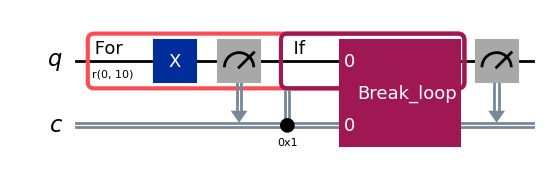

In [18]:
# Prepare quantum and classical bits
qubits = QuantumRegister(1, name='q')
clbits = ClassicalRegister(1, name='c')
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

# A loop to flip the qubit 10 times
with circuit.for_loop(range(10)) as i:
    circuit.x(q0)               # Apply X gate to flip the qubit state
    circuit.measure(q0, c0)     # Measure the state of q0
    with circuit.if_test((clbits, 1)):
        circuit.break_loop()  # Break the loop if the measurement result is 1

# Final measurement
circuit.measure(q0, c0)

# Visualize the circuit
circuit.draw('mpl')


In [19]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.c.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'1': 10000}


<div class="alert alert-block alert-warning">

아래 그림에서 IF 문 파란색 박스 오른쪽 변과 For 문 자주색 박스 오른쪽 변이 겹쳐져 있습니다. 즉 For 문 안에 If 문이 있습니다. 그림에서는 잘 안 보여 이렇게 말씀드립니다.

</div>

![Quantum circuit](../img/quantum_circuit.png)

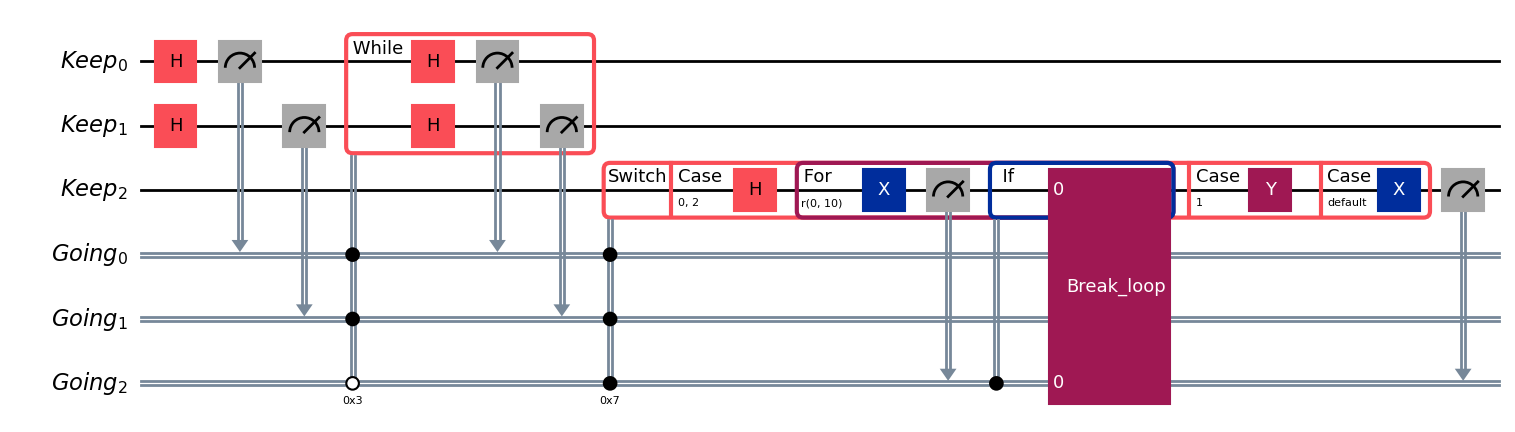

In [20]:
qubits = QuantumRegister(3, name='Keep')
clbits = ClassicalRegister(3, name='Going')
circuit = QuantumCircuit(qubits, clbits)
 
q0, q1, q2 = qubits
c0, c1, c2 = clbits

### Write your code below this line ### 

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.while_loop((clbits, 0b11)):
    circuit.h([q0, q1])
    circuit.measure(q0, c0)
    circuit.measure(q1, c1)

with circuit.switch(clbits) as case:
    with case(0b000, 0b010):
        circuit.h(q2)
        with circuit.for_loop(range(10)) as i:
            circuit.x(q2)
            circuit.measure(q2, c2)
            with circuit.if_test((c2, 1)):
                circuit.break_loop()
    with case(0b001):
        circuit.y(q2)
    with case(case.DEFAULT):
        circuit.x(q2)
 
circuit.measure(q2, c2)
 
### Do not change the code below this line ###

answer3 = circuit
fig = circuit.draw("mpl")
circuit.draw('mpl')

# fig.savefig('../img/quantum_circuit.png')

In [21]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.Going.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'100': 3325, '110': 3275, '101': 3400}


In [22]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge4c

grade_challenge4c(answer3, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


## Part 3: Repeat Until Success

Since quantum state measurement outcomes are probabilistic, there may be instances where the desired result does not appear. Depending on the algorithm you are developing, you may need a specific outcome from an intermediate measurement before proceeding with subsequent operations to obtain the desired result. A classic example of this is the HHL algorithm.

So, what should you do if an unwanted result appears during an intermediate measurement? Well... you try again! As long as the probability of getting the desired outcome is not zero, repeating the process will eventually yield the result you want.

Generally, you don't need to repeat too many times to get the desired outcome (it's a good practice to design algorithms with this in mind).

In this part, we will implement a $R_X(\theta)$ gate using the "repeat until success" method. You will be working with gates from the set $\{H, X, S, \text{Toffoli}\}$, and the task is to implement the $R_X(\theta)$ gate for cases where $\theta / \pi$ is irrational. Specifically, you will be rotating by an angle $\theta$ such that $\cos\theta = \frac{3}{5}$. This is related to the universality of the finite gate set, discussed in Exercise 4.41 of the 10<sup>th</sup> anniversary edition of the classic quantum computing textbook _Quantum Computation and Quantum Information_ by Nielsen and Chuang.

To implement this, you will need three qubits. One qubit will be designated as the "target" qubit, where the $R_X(\theta)$ gate will be applied. The other two qubits will be referred to as "syndrome" qubits. These will be measured to check whether the desired operation has been applied to the target qubit. In the circuit you'll build, if the syndrome qubits both measure to the $|0\rangle$ state, then the target qubit has had the desired operation applied. If not, all qubits must be reset and the process starts again.

What is the $R_X(\theta)$ Gate?

Let's first look at the formula for the $R_X(\theta)$ gate:

$$R_X(\theta) = \exp\left(-i\frac{\theta}{2}X\right) = \begin{bmatrix}\cos\left(\frac{\theta}{2}\right)&-i\sin\left(\frac{\theta}{2}\right)\\-i\sin\left(\frac{\theta}{2}\right)&\cos\left(\frac{\theta}{2}\right)\\ \end{bmatrix}$$

This is a single-qubit operation. What this means is that, on the Bloch sphere, the quantum state is rotated by an angle $\theta$ around the X-axis. Below, we will see an example of this operation.


Initial state


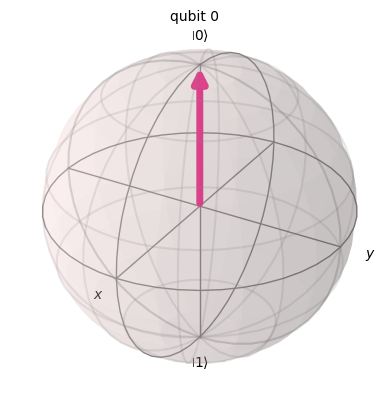


 Rotation of 30 degrees in the positive direction around the X-axis


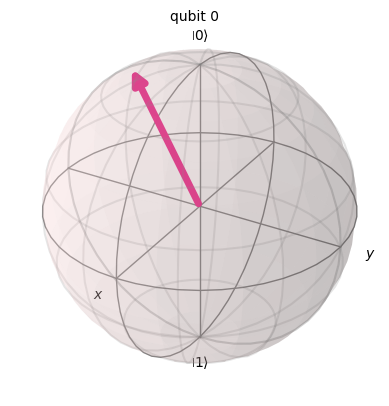


 Rotation of 30 degrees in the negative direction around the X-axis.


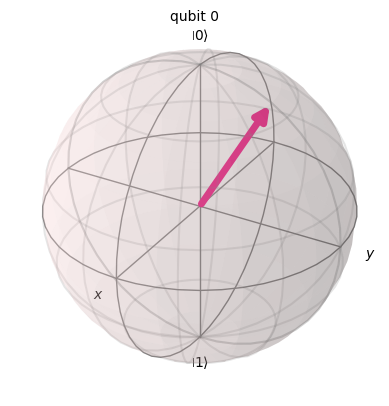


 Rotation of 90 degrees in the positive direction around the X-axis.


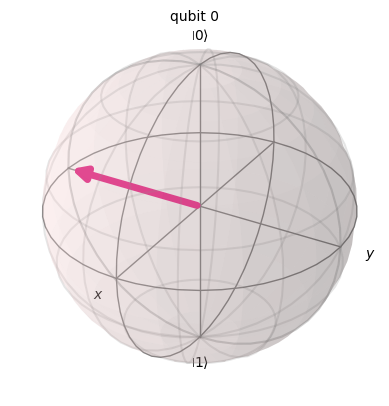

In [20]:
# Prepare single qubit quantum circuit
qc = QuantumCircuit(1)
print("Initial state")
display(plot_bloch_multivector(qc))

print("\n Rotation of 30 degrees in the positive direction around the X-axis")
qc = QuantumCircuit(1)
qc.rx(np.pi/6, 0)                               # 30 degrees = π/6 radians
display(plot_bloch_multivector(qc))

print("\n Rotation of 30 degrees in the negative direction around the X-axis.")
qc = QuantumCircuit(1)
qc.rx(-np.pi/6, 0)                              # -30 degrees = -π/6 radians
display(plot_bloch_multivector(qc))

print("\n Rotation of 90 degrees in the positive direction around the X-axis.")
qc = QuantumCircuit(1)
qc.rx(np.pi/2, 0)                               # 90 degrees = π/2 radians
display(plot_bloch_multivector(qc))

In [21]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

<div class="alert alert-block alert-success">

### Exercise 2: Make trial circuit

The first task you need to complete is to write a function that constructs a quantum circuit as shown in the diagram below.

![CircuitRX](../img/circuitRx.png)

To help you easily create the circuit, we have provided a `base` quantum circuit in the code cell above. The `base` quantum circuit is an empty circuit with 3 qubits and 3 classical bits.

**Task**: Complete the `trial` function in the code cell below. The `trial` function will create a quantum circuit following these steps:

1. Apply a Hadamard gate to each qubit in the quantum circuit.
2. Apply a Toffoli (controlled-controlled-not) gate to the control qubits and the target qubit. The Toffoli gate applies an $X$ gate to the target qubit when both control qubits are in the $|1\rangle$ state. To use the Toffoli gate, you can use the `.ccx()` method from the QuantumCircuit class.
3. Apply an $S$ gate to the target qubit.
4. Apply the same Toffoli gate (from Step 2) to the same control qubits and target qubit.
5. Apply a Hadamard gate to each qubit in the quantum circuit, just like in Step 1.
6. Measure the two control qubits.

</div>

In [ ]:
def trial(
    circuit: QuantumCircuit
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    
    ### Write your code below this line, making sure it's indented to where this comment begins from ### 
    
    # Hint: You can start solving this problem by coding like this
    # circuit.h([0,1,2])



    ### Do not change the code below this line ###


qc = base.copy_empty_like()
trial(qc)

qc.draw("mpl", cregbundle=False)

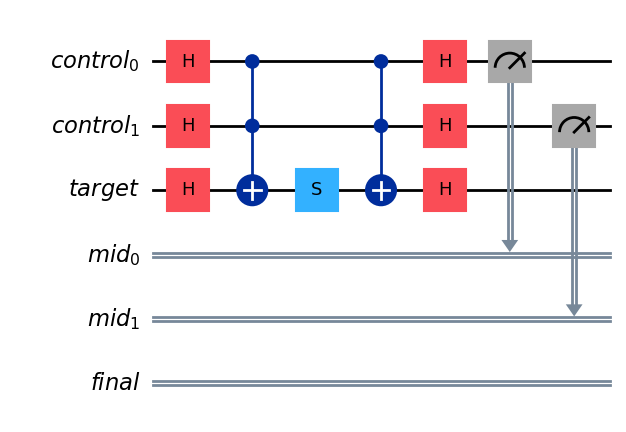

In [23]:
### solution ###

def trial(
    circuit: QuantumCircuit
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    
    ### Write your code below this line, making sure it's indented to where this comment begins from ### 
    
    # Hint: You can start solving this problem by coding like this
    # circuit.h([0,1,2])
    circuit.h([0,1,2])
    circuit.ccx(0,1,2)
    circuit.s(2)
    circuit.ccx(0,1,2)
    circuit.h([0,1,2])
    circuit.measure([0,1],[0,1])

    ### Do not change the code below this line ###


qc = base.copy_empty_like()
trial(qc)

qc.draw("mpl", cregbundle=False)

<div class="alert alert-block alert-success">

### Exercise 3: Make reset_controls function

The next task you need to complete is checking the measurement results. If both control qubits are observed in the state $|0\rangle$, the gate applied to the target qubit will be an $R_X(\theta)$ gate, where $\cos(\theta) = \frac{3}{5}$. If either of the control qubits is in the state $|1\rangle$, the gate applied to the target qubit will simply be an $X$ gate (you may want to verify this by performing the calculation yourself!). Therefore, by only measuring the two control qubits without touching the target qubit, you can verify if the correct gate has been applied to the target qubit.

If, after examining the measurement results, you conclude that the desired gate was not applied to the target qubit, you can reset the qubits and run the process again. If you know which gate was applied when the result was a failure, you can reset more efficiently. Specifically, if a control qubit was measured in the state $|1\rangle$, you can apply an $X$ gate to reset it to the state $|0\rangle$.

In the following cell, please complete the `reset_controls` function. The function should perform the following steps:

1. If the first control qubit's measurement result is 1, apply an $X$ gate to the first control qubit to reset it.
2. If the second control qubit's measurement result is 1, apply an $X$ gate to the second control qubit to reset it.

</div>

In [ ]:
def reset_controls(
    circuit: QuantumCircuit, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 

    

    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc)
reset_controls(qc, mid_measure)

qc.draw("mpl", cregbundle=False)

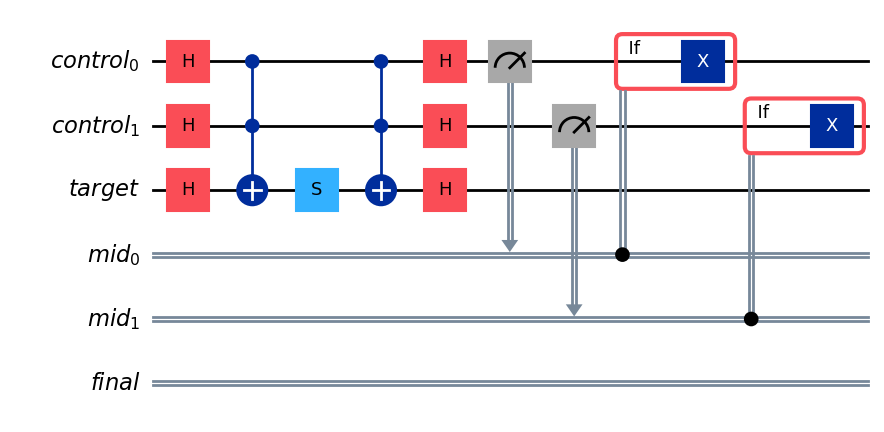

In [24]:
### solution ###

def reset_controls(
    circuit: QuantumCircuit, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 

    with circuit.if_test((measures[0],1)):
        circuit.x(0)
    with circuit.if_test((measures[1],1)):
        circuit.x(1)

    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc)
reset_controls(qc, mid_measure)

qc.draw("mpl", cregbundle=False)

Until last year, loops such as `while_loop`, `for_loop`, `break_loop`, and `continue_loop` did not exist, making it difficult to implement repeated operations based on conditions in Qiskit.

However, now Qiskit provides these loop structures, allowing us to execute repeat loops until success.

<div class="alert alert-block alert-success">

### Exercise 4: Repeating Until Success (Final)

It's finally time to complete the "Repeat Until Success" circuit. Do you remember the goal of the circuit we want to create? The goal is to apply an $R_X(\theta)$ gate with $\cos\theta = \frac{3}{5}$ on the target qubit using only the gates $\{H,\,X,\,S,\,\text{Toffoli}\}$.

In the code cell below, please complete the code inside the `while_loop`. The condition in the `while_loop` ([final_measure, 0b0]) is always satisfied. This means it's an infinite loop because the `final_measure` classical bit has not stored any measurement result before, so it always holds the initial value 0 until the final measurement.

**What to do**: Follow these steps to complete the code.

1. Inside the `while_loop`, first write the code to break the loop when the syndrome indicates success. Use the `if_test` and `break_loop` methods only once. Think about where the syndrome value is stored and what constitutes success.

2. If the syndrome measurement indicates that the desired operation was not applied to the target qubit, you will need to reset the target qubit to $|0\rangle$. As mentioned in the description of Exercise 6, if we fail to apply the desired operation, the target qubit will be in the $|1\rangle$ state due to the $X$ gate. To reset it to $|0\rangle$, we need to apply an $X$ gate. (Although other gates can also change $|1\rangle$ to $|0\rangle$, please use the $X$ gate for proper grading of the circuit.) Do **not** use the `else` statement!!

3. Call the `trial` function again to retry the circuit.

4. Call the `reset_controls` function to reset the control qubits properly.

</div>

In [ ]:
# Create a clean circuit with the same structure (bits, registers, etc) as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls are guaranteed to start in the |0> state.
trial(circuit)

reset_controls(circuit, mid_measure)
with circuit.while_loop(([final_measure, 0b0])): # Infinite loop
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 

    
    
    ## Do not change the code below this line ##

    
# We need to measure the control qubits again to ensure we get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

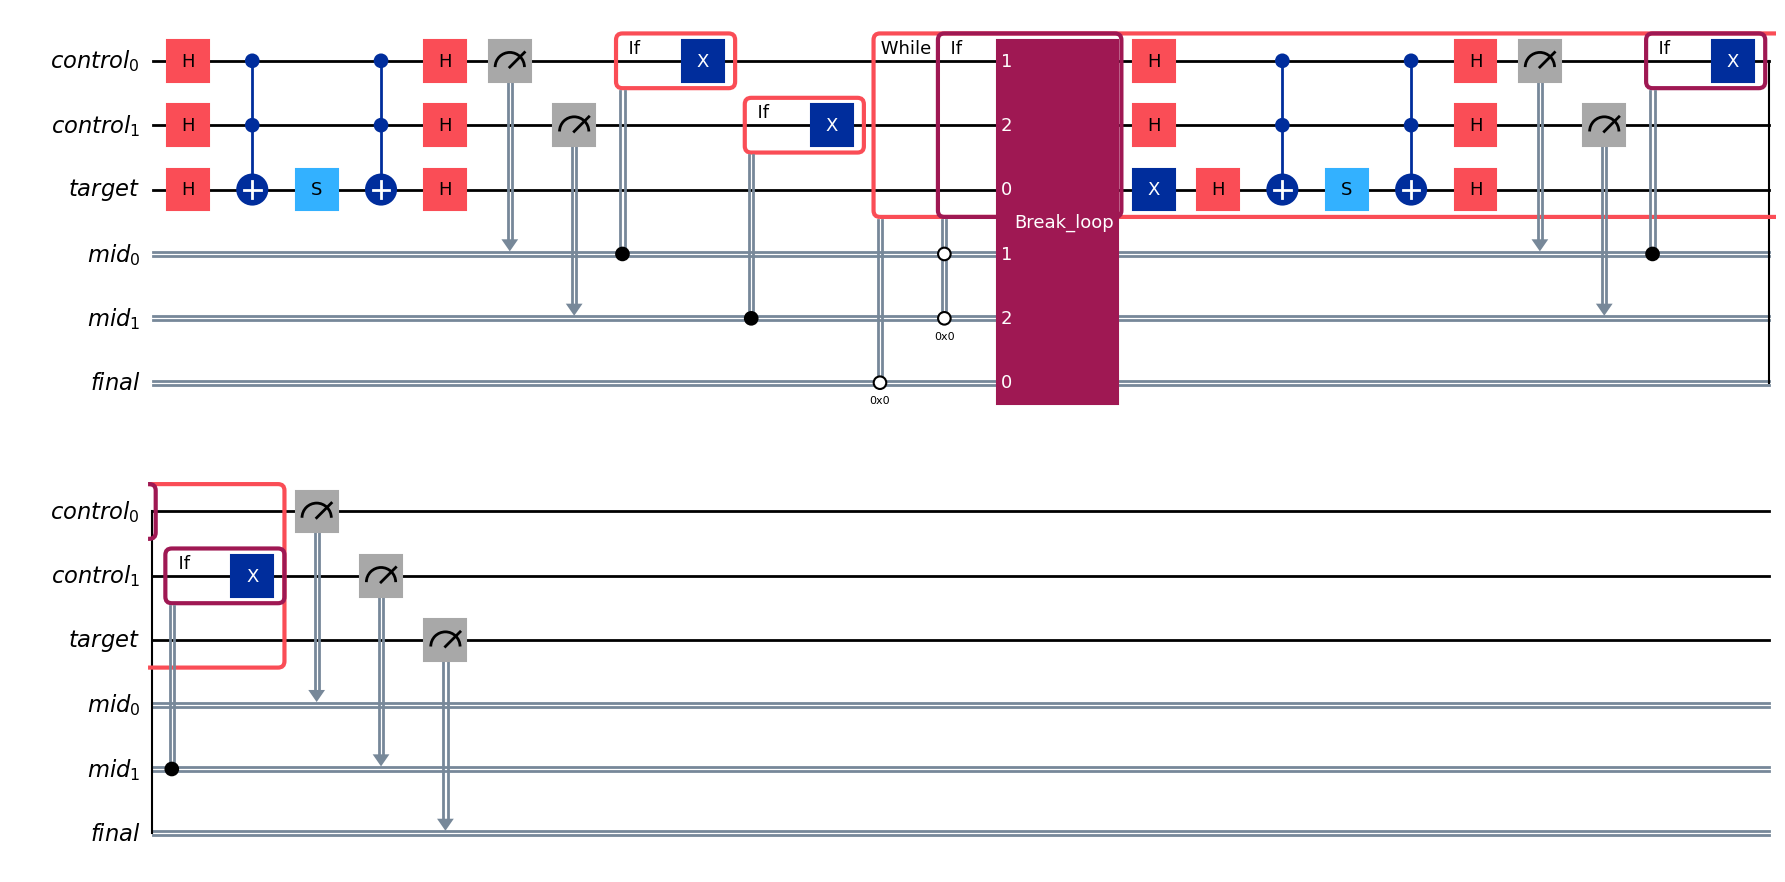

In [26]:
### solution ###

# Create a clean circuit with the same structure (bits, registers, etc) as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls are guaranteed to start in the |0> state.
trial(circuit)

reset_controls(circuit, mid_measure)
with circuit.while_loop(([final_measure, 0b0])): # Infinite loop
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    with circuit.if_test((mid_measure, 0b00)):
        circuit.break_loop()
    circuit.x(target)
    trial(circuit)
    reset_controls(circuit, mid_measure)
    
    ## Do not change the code below this line ##

    
# We need to measure the control qubits again to ensure we get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

In [27]:
# initialize the backend and sampler
backend = AerSimulator()
sampler = Sampler(backend)

# Make a pub and execute our circuit
pub = (circuit)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.final.get_counts()

print(f"Counts: {counts_sampler}")

Counts: {'0': 7956, '1': 2044}


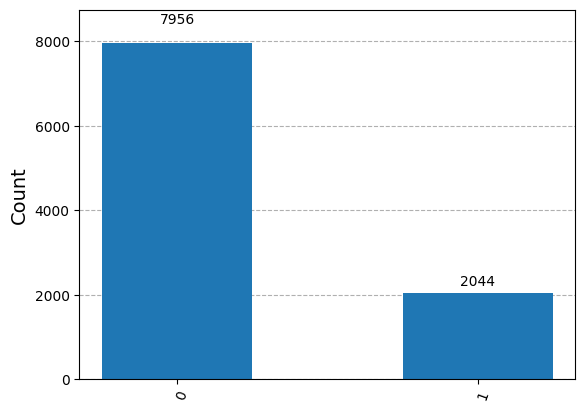

In [28]:
plot_histogram(counts_sampler)

Did you successfully apply the $R_X(\theta)$ gate with $\cos\theta = \frac{3}{5}$ to the target qubit? Congratulations!

<div class="alert alert-block alert-info">

$R_X(\theta)$ is the following operation:

$$R_X(\theta) = \exp\left(-i\frac{\theta}{2}X\right) = \begin{bmatrix}\cos\left(\frac{\theta}{2}\right)&-i\sin\left(\frac{\theta}{2}\right)\\-i\sin\left(\frac{\theta}{2}\right)&\cos\left(\frac{\theta}{2}\right)\\ \end{bmatrix}$$

Earlier, you applied the $R_X(\theta)$ gate with $\cos\theta = \frac{3}{5}$ to the target qubit. When this operation is applied, the probability of measuring $|0\rangle$ and $|1\rangle$ for the target qubit are 4/5 and 1/5, respectively. Compare these measurement results with the theoretical values.

</div>

## Congratulations!

Congratulations! You have now mastered how to implement classical feedforward and control flow in Qiskit!